(bids_folders)=
# Working with BIDS folders
Author: Nicolas Legrand <nicolas.legrand@cfin.au.dk>

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install systole

Starting in version `0.2.3`, Systole provides tools to interact with large datasets of physiological recordings. The functionalities interface with folders that are structured following the [BIDS standards](https://bids-specification.readthedocs.io/en/stable/) and this is the format we recommend using if you are following this tutorial.

Following the BIDS specifications, physiological recordings, sometimes associated with behavioural tasks or neural recordings, are stored with a filename ending with `*_physio.tsv.gz` and are always accompanied with sidecar a `*_physio.json` file containing metadata like the recording modality or the sampling frequency. Accessing both the times series and its accompanying metadata will help Systole automate the preprocessing by finding the correct parameters for peaks detection and reports.

A valid BIDS folder should be structured like the following:

```
└─ BIDS/
   ├─ sub-0001/
   │  └─ ses-session1/
   │     └─ beh/
   │        ├─ sub-0001_ses_session1_task-mytask_physio.tsv.gz
   │        └─ sub-0001_ses_session1_task-mytask_physio.json
   │
   ├─ sub-0002/
   ├─ sub-0003/
   └─ ... 
```

Here, we have physiological recordings associated with a behavioural task for `n` participants in the folder.

```{tip}
We recommend using tools like [BIDS validator](https://bids-standard.github.io/bids-validator/) to ensure that your folder complies with BIDS specification before trying to preprocess your data, or to use the editor.
```

(preprocessing)=
## Preprocessing

The first step will be to preprocess the raw data and store the signal and peaks detection in a new derivative folder. During this step, we can also decide to create HTML reports for each participants, so we can visualize the signal quality and peaks detection.

### Preprocessing the physiological data from one participant

The :py:func:`systole.reports` sub-module contains tools to directly interact with BIDS formatted folders, preprocess and save individual reports in a BIDS consistent way. Those functionalities are built on the top of the:py:func:`systole.reports.subject_level_report` function. This function will simply take a signal as input and will save as output the preprocessed signal with peaks detection (`_physio.tsv.gz` with the `_physio.json`), an `.html` reports adapted to the kind of signal that was provided, and a `features.tsv` file containing heart rate or respiratory rate variability features.

For example, running the following code:


```python
from systole import import_dataset1
from systole.reports import subject_level_report

ecg = import_dataset1(modalities=["ECG"]).ecg.to_numpy()

subject_level_report(
    participant_id="participant_test",
    pattern="task_test",
    result_folder="./",
    session="session_test",
    ecg=ecg,
    ecg_sfreq=1000,
)
```

will save these four new files in the file folder.
1. The `.html` file is a standalone document that can be visualized in the browser.
2. The `features.tsv` contains heart rate and/or respiration rate variability metrics.
3. The `_physio.tsv.gz` and the `_physio.json` files contain the preprocessed signal with new columns `peaks` for peaks detection.

### Preprocessing the entire BIDS folder

The previous function call can be automated for each participant and each file of a given BIDS folder and to extract the physiological features using the information provided in the `json` metadata automatically. This can be done using the:py:func:`systole.reports.wrapper` function, or directly from the command line. For example, the following command:

```bash
systole --bids_folder="/path/to/BIDS/folder/" \
        --patterns="task-mytask" \
        --modality="beh" \
        --n_jobs=10 \
        --overwrite=True \
        --html_reports==False
```

will preprocess the data for all participants with a physiological recording in the session `ses-session1` (default), for the behavioural modality (`beh`) and the task `mytask`. We set `n_jobs=10`, meaning that we will run 40 processes in parallel, and `overwrite=True` to overwrite previous data with the same ID in the derivative folder. Note that we also set `html_reports` to `False` as these files can be quite large, it is often preferable to only create it for the participant we want to review, or to use the {ref}`viewer`. The possible arguments are:

```{list-table} Command line arguments
:header-rows: 1
:name: label-to-reference

* - Argument
  - Description
* - --bids_folder (-i)
  - --participant_id (-p)
  - --patern (-t)
  - --html_reports (-r)
  - --result_folder (-o)
  - --n_jobs (-n)
  - --modality (-d)
  - --overwrite (-w)
* - Path to the BIDS folder containing the physiological recordings.
  - The id of the participant that should be preprocessed. If this argument is not provided, all the participants will be preprocessed.
  - Only the files that contains the pattern string will be preprocessed. If the number of files matching is not exactly 1, the files are not processed. 
  - Create subject-level HTML reports if `True`.
  - Path to the result folder. If not provided, the default will be ./derivatives/systole/.
  - The number of jobs to run concurrently.
  - The modality of the recording (i.e. `"beh"`, `"func"`...).
  - If `True`, overwrite preexisting files in the result folder (DOES NOT include the corrected files).  
```

```{note}
When setting `overwrite=True`, only the preprocessed derivatives will be overwritten, but not the edited files located in `BIDS/systole/derivatives/corrected/*`. This means that it is possible to re-run the preprocessing event after working on the manual artefacts edition (see below).
```

Once the preprocessing is completed, and if you did not asked for an external result folder, the structure of the BIDS repository should now include a new `systole` folder in the derivatives:

```
└─ BIDS/
   ├─ derivatives/
   │  └─ systole/
   │     └─ sub-0001/
   │         └─ ses-session1/
   │            └─ beh/
   │               ├─ sub-0001_ses_session1_task-mytask_features.tsv
   │               ├─ sub-0001_ses_session1_task-mytask_report.html
   │               ├─ sub-0001_ses_session1_task-mytask_physio.tsv.gz
   │               └─ sub-0001_ses_session1_task-mytask_physio.json
   ├─ sub-0001/
   │  └─ ses-session1/
   │     └─ beh/
   │        ├─ sub-0001_ses_session1_task-mytask_physio.tsv.gz
   │        └─ sub-0001_ses_session1_task-mytask_physio.json
   │
   ├─ sub-0002/
   ├─ sub-0003/
   └─ ... 
```

(viewer)=
## Manual edition of peaks vector and bad segments labelling

While we hope that the peaks detection function used by [Systole](https://embodied-computation-group.github.io/systole/#) is sufficiently robust to extract peak vectors without errors for most of the uses cases, you might still encounter noisy or invalid recording that you will want to manually inspect and sometimes edit.

The :py:mod:`systole.interact` sub-module provides two classes (:py:class:`systole.interact.Editor` and :py:class:`systole.interact.Viewer`) built on the top of Matplotlib widgets that can help for manual edition, and interactive visualization of BIDS fodlers directly in the notebook.

### Using the Editor to inspect raw signal

The :py:mod:`systole.interact.Editor` can be use alone (apart from a BISD structured folder) to edit peaks detection from a raw ECG, PPG or respiratory signal.

In [2]:
from systole import import_dataset1
from systole.interact import Viewer, Editor
from IPython.display import display

%matplotlib ipympl

In [3]:
# Load a ray ECG time series
ecg = import_dataset1(modalities=['ECG'], disable=True).ecg.to_numpy()

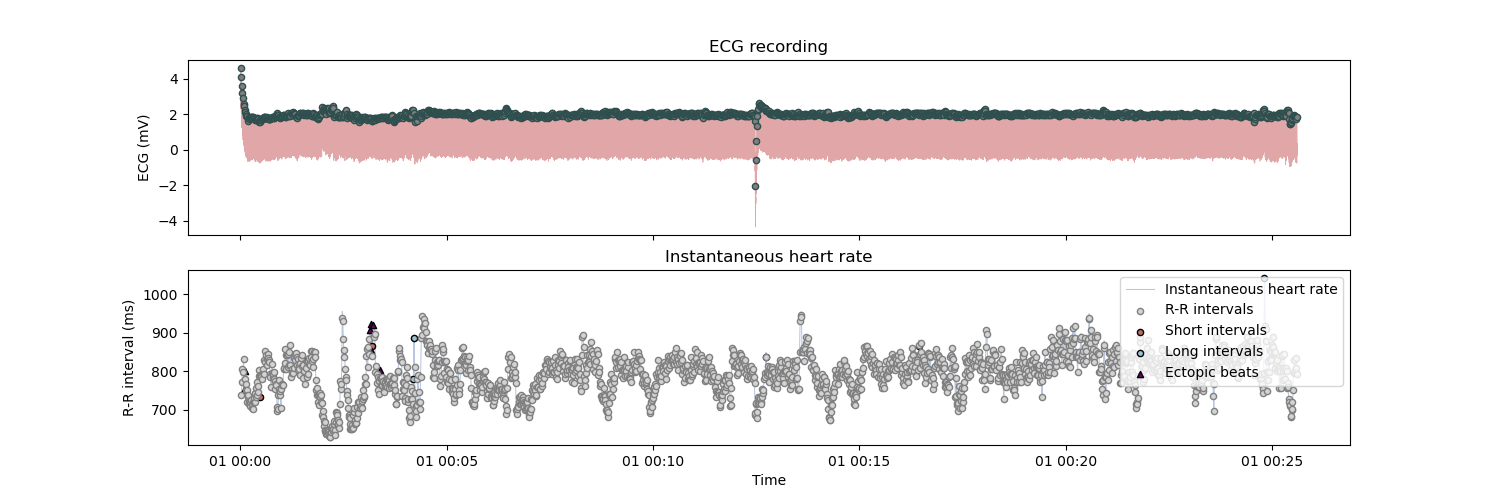

In [4]:
editor = Editor(
    signal=ecg,
    sfreq=1000,
    corrected_json="./corrected.json",
    figsize=(15, 5),
    signal_type="ECG"
)
display(editor.commands_box)

```{note}
Note that we are using the package [ipympl](https://matplotlib.org/ipympl/), and activating it using the magic cell `%matplotlib ipympl` so we can render Matplotlib interactive widgets in the Notebook. If you are working in another IDE, you can also render the same windows using a different backend like PyQt.
```

This windows will automatically apply peaks detection given the `signal_type` parameter, and plot the raw signal with the instantaneous heart / respiration rate to check for artefacts. The class embed a `command_box` that can be used for edition. 

* When using the **Correction** mode:
    * Use the *left* mouse button to select segment where all the peaks should be removed.
    * Use the *right* mouse button to select segment where peak will be added at the local maximum.
    <p align='center'><img src='https://github.com/embodied-computation-group/systole/raw/dev/docs/source/images/peaks.gif'/></p>

* When using the **Rejection** mode:
    * Use the *right* mouse button to select a segment that should be marked as bad.
    <p align='center'><img src='https://github.com/embodied-computation-group/systole/raw/dev/docs/source/images/segments.gif'/></p>

* By deselecting the check box, you can mark the entire signal as **invalid**.

* Once that the signal has been edited, you can **save** the modification using the `Save modification` button, or directly use the method from the class.

In [5]:
editor.save()

Saving modification in ./corrected.json


This function will create a JSON file (using the path specified in the `corrected_json` parameter) with all the information about bad segments labelling, peaks deletion and peaks insertion. The JSON file contains the following entries for each modality (ECG, PPG and respiration)

* `valid` : is the recording valid or should it be discared (`True` unless otherwise stated).
* `corrected_peaks` : the peaks indexes after correction.
* `bad_segments` : a list of `start` and `end` indexed of bad segments.

### Using the Viewer to navigate preprocessed folder

The :py:mod:`systole.interact.Viewer` class wrap the Editor and allows to easily navigate and edit folder that contains large number of recoring. You can for example simply read the results generated by the command line (see {ref}`preprocessing`). Considering that the files were create in the folder `"/path/to/BIDS/folder/derivatives/systole/"` (which is the default behavior if `--result _folder is not provided`), the Viewer can be called using:

```python
from IPython.display import display
from systole.interact import Viewer

%matplotlib ipympl
```

```python
view = Viewer(
    figsize=(15, 5),
    preprocessed_folder="/path/to/BIDS/folder/derivatives/systole/",
    pattern="task-my_task", # A string long enough to disambiguate in case of mmultiple recordings
    modality="beh",
    signal_type="ECG"
)
```

```python
display(view.io_box, view.editor.commands_box, view.output)
```

This will create an interactive windows where all the preprocessed ECG recordings from the behavioral task `my_task` can be inspected and further edited.

<p align='center'><img src='https://github.com/embodied-computation-group/systole/raw/dev/docs/source/images/editor.gif'/></p>

```{note}
If the signal was previously edited, the Viewer will automatically load the edited version and display bad segment (if any).
```

### Using the Viewer to navigate BIDS folder

Using the same logic, the :py:mod:`systole.interact.Viewer` can also work with the raw BIDS folder, instead of the derivatives, and preprocess data on the fly. This mode is more appropriate if you want to quickly inspect the data and do not want to generate subject or group level reports. The only different is that the input path should be parameter using the `bids_folder` argument, instead of `preprocessed_folder`. This will make the viewer aware that the signal are located in this folder, but that previously edited signal might also be located in `./derivatives/systole/corrected/`.


```python
view = Viewer(
    figsize=(15, 5),
    bids_folder="/path/to/BIDS/folder/",
    pattern="task-my_task", # A string long enough to disambiguate in case of mmultiple recordings
    modality="beh",
    signal_type="ECG"
)
```

### Importing signals after manual edition

After manual peaks correction and segments labelling, a new `corrected` subfolder will be appended to the systole derivatives:

```
└─ BIDS/
   ├─ derivatives/
   │  └─ systole/
   │     ├─ corrected/
   │        └─ sub-0001/
   │           └─ ses-session1/
   │              └─ beh/
   │                 └─ sub-0001_ses_session1_task-mytask_physio.json
   │     └─ sub-0001/
   │         └─ ses-session1/
   │            └─ beh/
   │               ├─ sub-0001_ses_session1_task-mytask_features.tsv
   │               ├─ sub-0001_ses_session1_task-mytask_report.html
   │               ├─ sub-0001_ses_session1_task-mytask_physio.tsv.gz
   │               └─ sub-0001_ses_session1_task-mytask_physio.json
   ├─ sub-0001/
   │  └─ ses-session1/
   │     └─ beh/
   │        ├─ sub-0001_ses_session1_task-mytask_physio.tsv.gz
   │        └─ sub-0001_ses_session1_task-mytask_physio.json
   │
   ├─ sub-0002/
   ├─ sub-0003/
   └─ ... 
```